<a href="https://colab.research.google.com/github/meiruv/IMDB_sentiment_analysis/blob/main/Fine_Tuning_HuggingFace_For_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers[sentencepiece]


     |████████████████████████████████| 290 kB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 48.1 MB/s 
     |████████████████████████████████| 132 kB 45.5 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 243 kB 56.7 MB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 192 kB 50.6 MB/s 
     |████████████████████████████████| 271 kB 54.2 MB/s 
     |████████████████████████████████| 160 kB 55.3 MB/s 
     |████████████████████████████████| 3.3 MB 57.9 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Loading the data and some exploratory 
- classes distribution
- length of sequences distribution
- anything else?

In [2]:
reviewsFile = open('reviews.txt','r')
reviews = list(map(lambda x:x[:-1],reviewsFile.readlines()))
reviewsFile.close()

labelsFile = open('labels.txt','r')
labels = list(map(lambda x:x[:-1],labelsFile.readlines()))
labelsFile.close()



In [3]:
print('# of reviews: ', len(reviews))
print('# of labels: ', len(labels))
print(set(labels))

# of reviews:  25000
# of labels:  25000
{'negative', 'positive'}


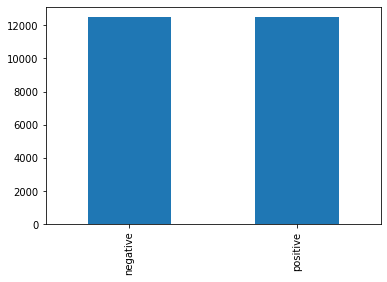

In [12]:
import pandas as pd
#  labels distributions
pd.Series(labels).value_counts().plot.bar()

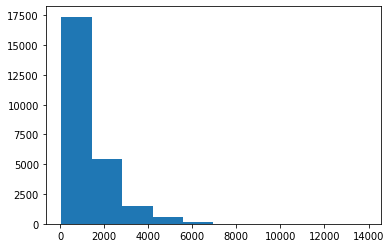

In [21]:
import numpy as np
from matplotlib import pyplot as plt

reviews_len = [len(x) for x in reviews]

_, bins = pd.cut(reviews_len, bins = 10, retbins=True)
plt.hist(reviews_len, bins);

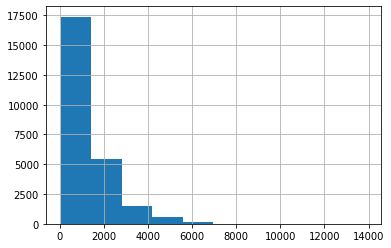

In [24]:
pd.Series(reviews_len).hist();

In [26]:
sum(i > 6000 for i in reviews_len)

53

In [27]:
data_df = pd.DataFrame(data={'labels':labels,'reviews_len':reviews_len})
data_df.head()

,labels,reviews_len
0,positive,832
1,negative,667
2,positive,2398
3,negative,4476
4,positive,857


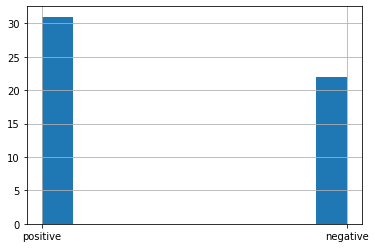

In [29]:
data_df[data_df['reviews_len']>6000]['labels'].hist();

# Why should we use an existing model instead of training our own?
put in a summary from the hugging face course

# Trying to use the sentiment analysis pipeline
crashes in the following ways -
1. giving wrong predictions here and there
2. not managing to operate on too long sequences (reviews[4])

print out the model's as is accuracy and then see if we can improve it

In [30]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
print('True Label: ',labels[0],'   Model Prediction: ',classifier(reviews[0]))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

True Label:  positive    Model Prediction:  [{'label': 'NEGATIVE', 'score': 0.9980175495147705}]


In [31]:
for i in range(5):

  print('True Label: ',labels[i],'   Model Prediction: ',classifier(reviews[i]))


True Label:  positive    Model Prediction:  [{'label': 'NEGATIVE', 'score': 0.9980175495147705}]
True Label:  negative    Model Prediction:  [{'label': 'NEGATIVE', 'score': 0.6425657272338867}]


Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors


True Label:  positive    Model Prediction:  [{'label': 'NEGATIVE', 'score': 0.9877837300300598}]


RuntimeError: ignored

In [32]:
print(reviews_len[3])

4476


So the model is not accurate enough and it also can't handle some of the lengths in our data. let's fine tune it :)

In [33]:
# Checking overall accuracy of the model before tuning 

# Fine tuning our own model


# 1. Which model are we tuning?
There are two ways in which one can find a model to start from -
1. Use the default one for this task. For example here, when we ran the sentiment analysis pipeline what happened behind the scenes is that a pretrained model from huggingface's hub has been ran on our dataset. But how do we know which model ran? because it was printed as output -

**Need to find how to manually check this in case it's not printed out**


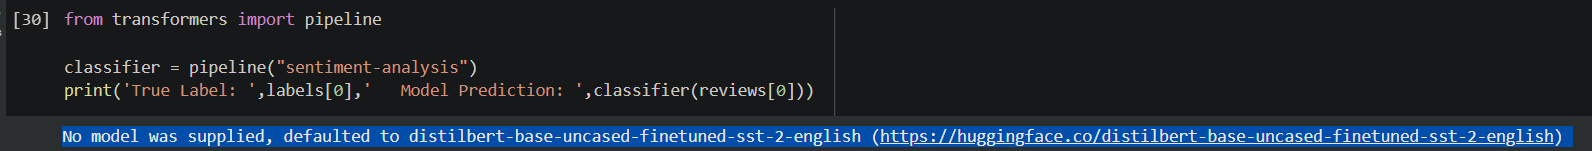

2. Choose one from the hub. On the left side there are criterion to choose from - Tasks - in our case it will be text classification
- Libraries - I wanted PyTorch but if you go with TensorFlow I won't be offended
- Languages - en

On the right there will be the relevans datasets ordered by downloads. Not surprisingly, the most used model is distilbert which was also the default for this task. I guess it's meant to be.

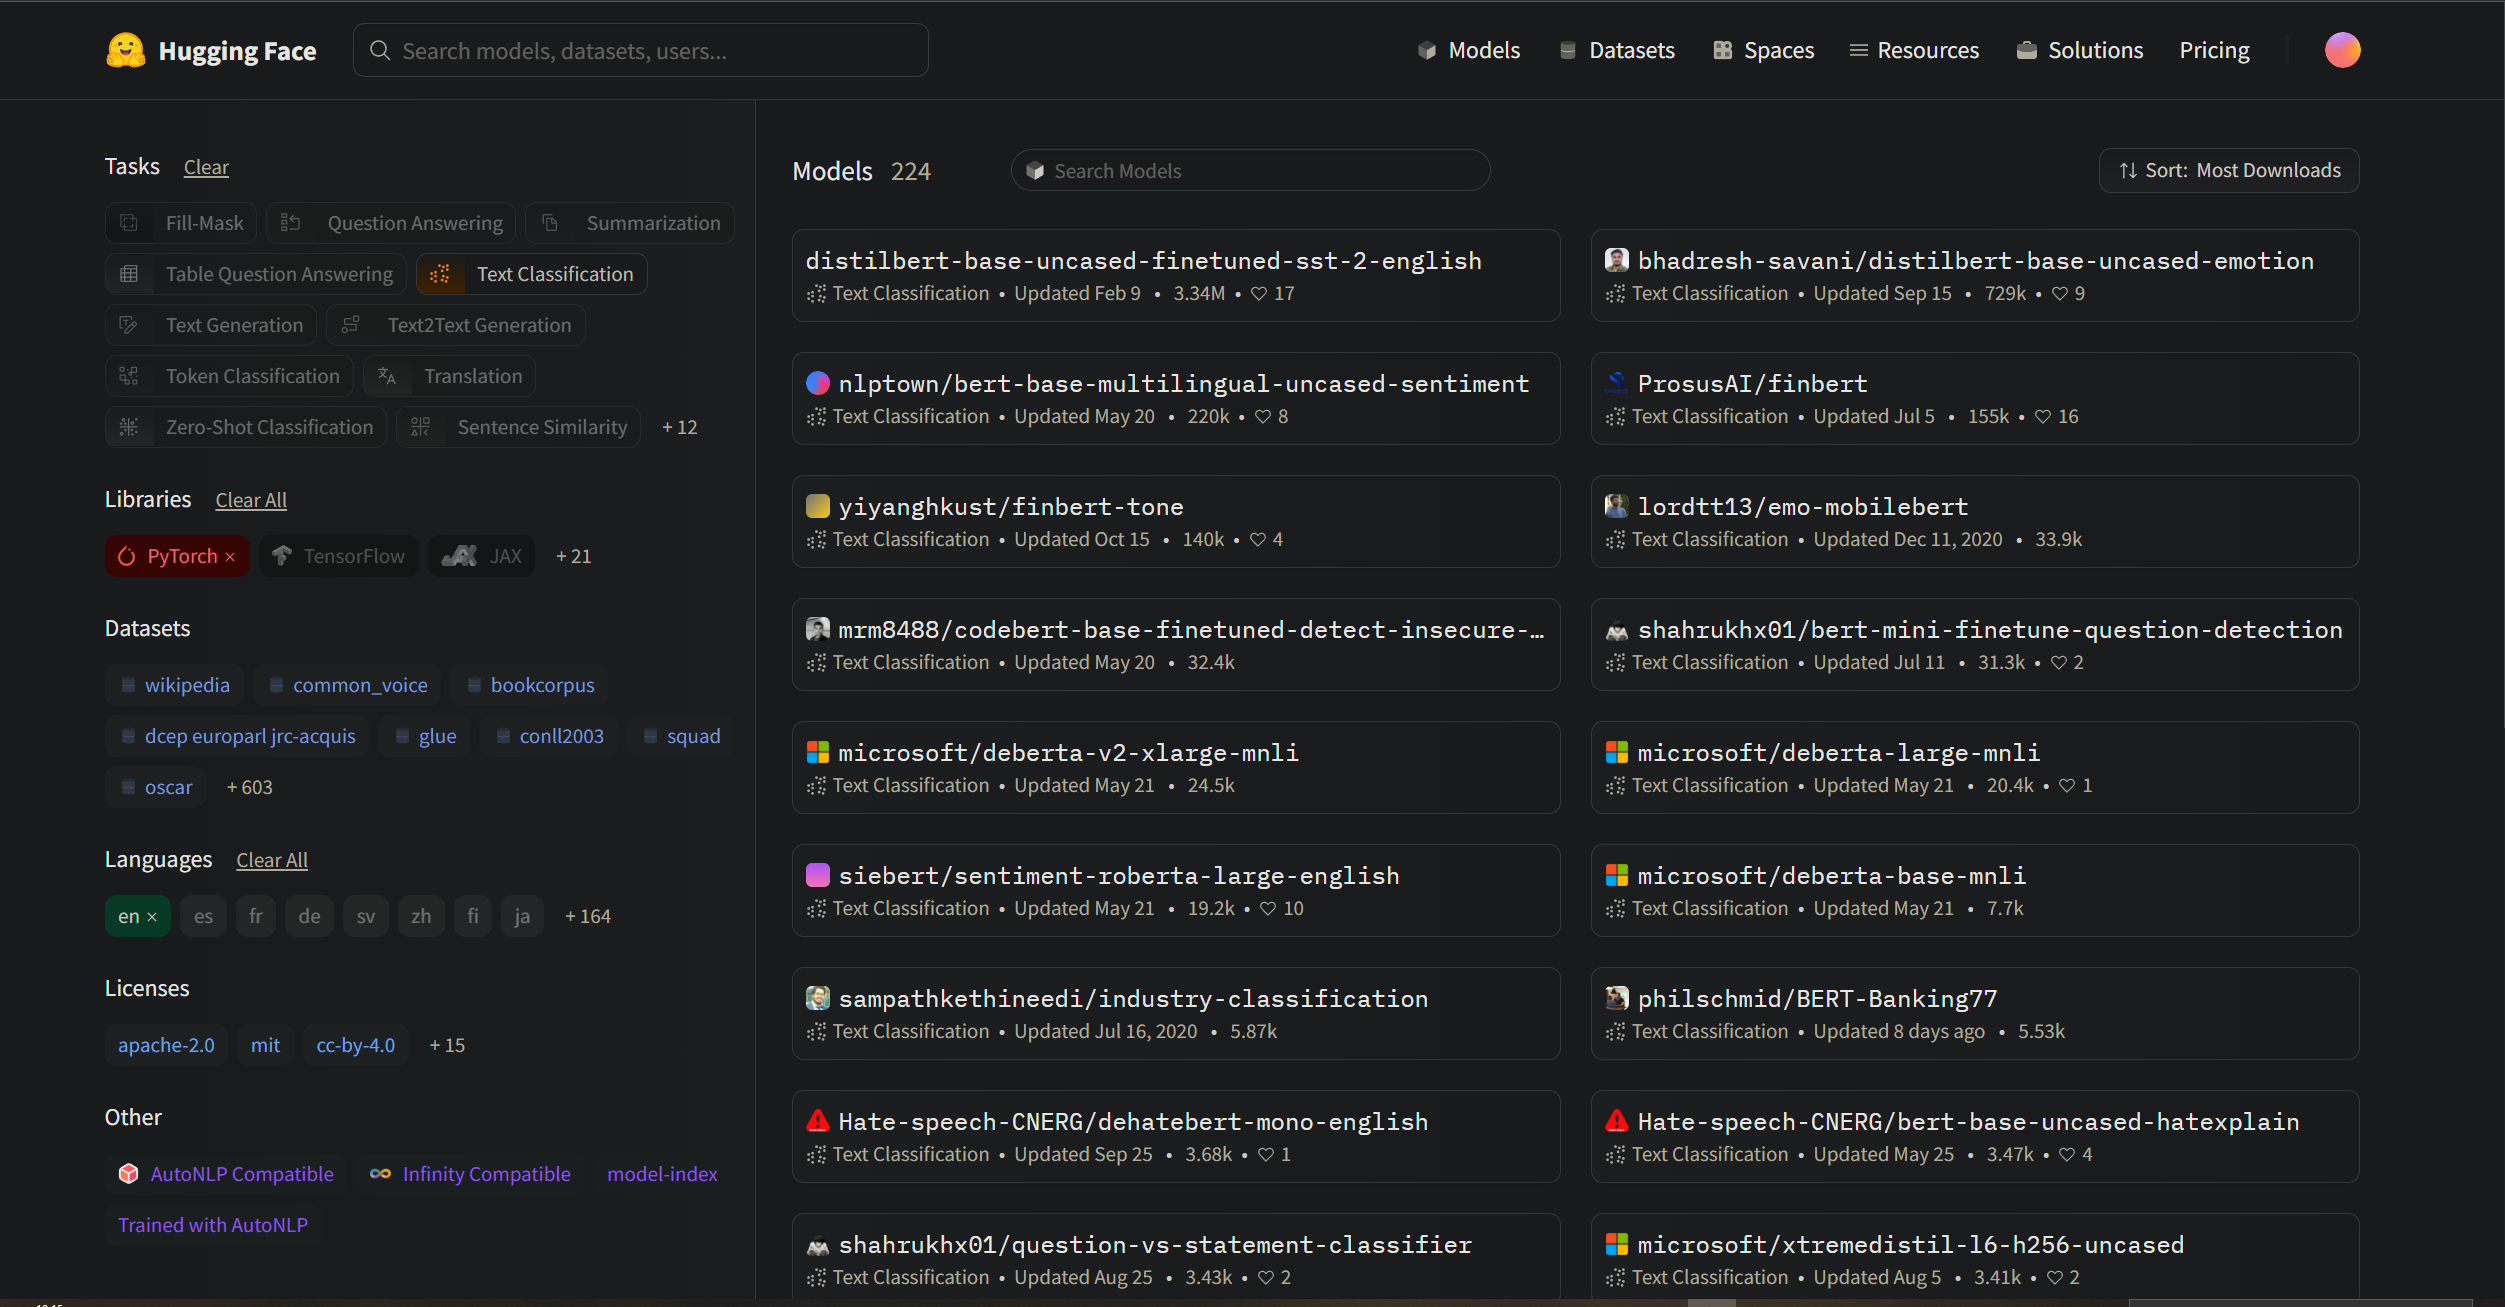

## 2. Tuning -
use the loop from the course and explain important parts -
- accelerate
- map
- dataloaders?


# Loading the data

In [37]:
df = pd.DataFrame(data = {'reviews':reviews,'labels':labels})
df.head()
df.to_csv('reviews.csv')

In [39]:
df.head()

,reviews,labels
0,bromwell high is a cartoon comedy . it ran at ...,positive
1,story of a man who has unnatural feelings for ...,negative
2,homelessness or houselessness as george carli...,positive
3,airport starts as a brand new luxury pla...,negative
4,brilliant over acting by lesley ann warren . ...,positive


In [46]:
df.to_json('reviews.json')

In [48]:
from datasets import load_dataset
dataset = load_dataset('text', 'reviews.txt')

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Using custom data configuration reviews.txt-3f33d0a38cd8979f


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/reviews.txt-3f33d0a38cd8979f/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 125689
    })
})

In [49]:
#  ------------------------------------   Need to understand how to have the labels here as well and also how to split this into train, test and val --------------------------